<h1>SCA using neural networks</h1>

In [21]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, Flatten, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import load_model

<h3>Load the data</h3>

In [2]:
filename = './SCA/ASCAD.h5'

In [22]:
def load_ascad(file_path, num_traces=None):
    with h5py.File(file_path, 'r') as f:
        X_profiling = np.array(f['Profiling_traces/traces'])[:num_traces]
        Y_profiling = np.array(f['Profiling_traces/labels'])[:num_traces]
        X_attack = np.array(f['Attack_traces/traces'])[:2000]
        Y_attack = np.array(f['Attack_traces/labels'])[:2000]
        
        metadata_attack = f['Attack_traces/metadata']
        plaintexts_attack = np.array(metadata_attack['plaintext'])[:2000]
        key = np.array(metadata_attack['key'])[:2000]
    
    return (X_profiling, Y_profiling), (X_attack, Y_attack), plaintexts_attack, key

<h3>Visualize the data</h3>

Keys del archivo: ['Attack_traces', 'Profiling_traces']
Traces de entrenamiento: (50000, 700)
Etiquetas de entrenamiento: (50000,)
Traces de ataque: (10000, 700)
Etiquetas de ataque: (10000,)


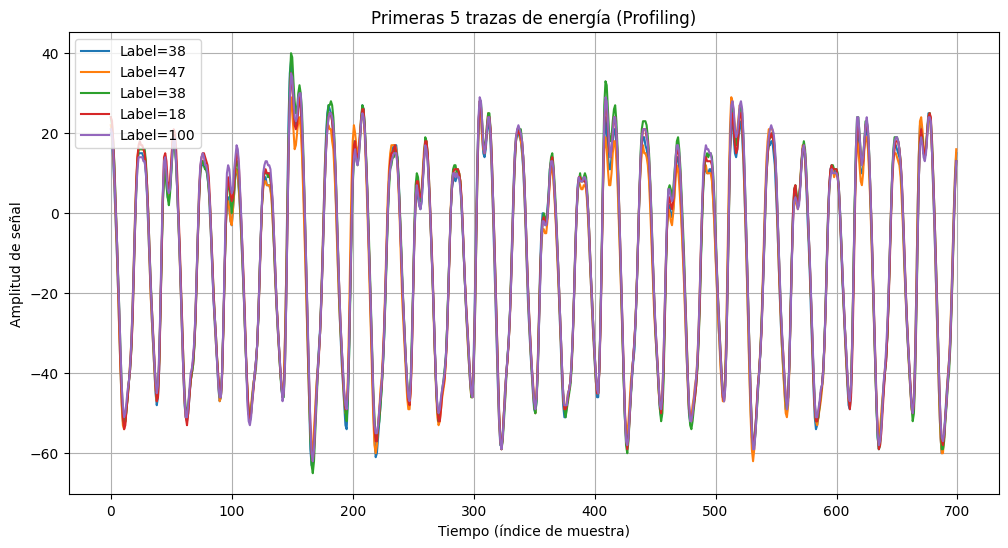

In [23]:
with h5py.File(filename, 'r') as f:
    print("Keys del archivo:", list(f.keys()))

    traces = f['Profiling_traces/traces']
    labels = f['Profiling_traces/labels']
    traces = np.array(traces[:])
    labels = np.array(labels[:])

    X_train = np.array(f['Profiling_traces/traces'])
    Y_train = np.array(f['Profiling_traces/labels'])
    X_val = np.array(f['Attack_traces/traces'])
    Y_val = np.array(f['Attack_traces/labels'])

    print("Traces de entrenamiento:", X_train.shape)
    print("Etiquetas de entrenamiento:", Y_train.shape)
    print("Traces de ataque:", X_val.shape)
    print("Etiquetas de ataque:", Y_val.shape)

num_traces_to_plot = 5

plt.figure(figsize=(12, 6))
for i in range(num_traces_to_plot):
    plt.plot(traces[i], label=f"Label={labels[i]}")

plt.title("Primeras 5 trazas de energía (Profiling)")
plt.xlabel("Tiempo (índice de muestra)")
plt.ylabel("Amplitud de señal")
plt.legend()
plt.grid(True)
plt.show()

<h3>Split data into trainig, validation and test</h3>

In [24]:
(X_profiling, Y_profiling), (X_attack, Y_attack), plaintexts_attack, key = load_ascad(filename)
X_train, X_val, Y_train, Y_val = train_test_split(X_profiling, Y_profiling, test_size=0.1, random_state=42)

<h3>Scaling data</h3>

In [25]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_attack = scaler.transform(X_attack)

<h3>Preprocessing data</h3>

In [26]:
Y_profiling = to_categorical(Y_profiling, num_classes=256)
Y_train = to_categorical(Y_train, num_classes=256)
Y_val = to_categorical(Y_val, num_classes=256)
Y_attack = to_categorical(Y_attack, num_classes=256)

X_profiling = X_profiling.reshape((X_profiling.shape[0], X_profiling.shape[1], 1))
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))
X_attack = X_attack.reshape((X_attack.shape[0], X_attack.shape[1], 1))

<h3>Build simple model for testing</h3>

In [27]:
model = Sequential([
    Conv1D(32, kernel_size=3, activation='relu', input_shape=(X_profiling.shape[1], 1)),
    Dropout(0.2),
    Conv1D(64, kernel_size=3, activation='relu'),
    Dropout(0.2),
    Flatten(),
    Dense(256, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


c:\Users\ricor\OneDrive\Desktop\SCA\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [28]:
model.fit(X_train, Y_train, epochs=10, batch_size=200, validation_data=(X_val, Y_val))
model.save('ascad_model.h5')

Epoch 1/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 29s 126ms/step - accuracy: 0.0040 - loss: 5.6972 - val_accuracy: 0.0052 - val_loss: 5.5448
Epoch 2/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 28s 123ms/step - accuracy: 0.0081 - loss: 5.5265 - val_accuracy: 0.0036 - val_loss: 5.5515
Epoch 3/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 28s 124ms/step - accuracy: 0.0382 - loss: 5.2165 - val_accuracy: 0.0026 - val_loss: 5.7601
Epoch 4/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 28s 125ms/step - accuracy: 0.2747 - loss: 3.5860 - val_accuracy: 0.0028 - val_loss: 6.7625
Epoch 5/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 28s 124ms/step - accuracy: 0.6497 - loss: 1.5513 - val_accuracy: 0.0030 - val_loss: 8.3444
Epoch 6/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 28s 124ms/step - accuracy: 0.8821 - loss: 0.5037 - val_accuracy: 0.0032 - val_loss: 10.2605
Epoch 7/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 27s 122ms/step - accuracy: 0.9513 - loss: 0.1971 - val_accuracy: 0.0032 - val_loss: 11.5786
Epoch 8/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 28s 122ms/step - accuracy: 0.9711 - loss: